# Computing SEACells based on scATAC

Since in the notebooks and tutorials they recommend using ATAC data for computing metacells this is what I will do here. Instead of using SVD I will use the 10 dimensional latent embedding obtained with PeakVI.

# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import SEACells
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams['figure.dpi'] = 100


In [3]:
data_dir = "/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/"

# Load Data

Here I will use the ArchR object to compute SEACells. Instead of using the SVD latent embedding, I will train a PeakVI model on this object. 
The RNA data object was also converted from the ArchR object.

### Import peak data from ArchR

#### Peaks

# Build our anndata object from the matrices in ArchR
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'ArchR_object/peak_counts/counts.mtx')

# Cell and peak information
cells = pd.read_csv(data_dir + 'ArchR_object/peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'ArchR_object/peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

# create anndata for peaks
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]
    
ad.X = ad.X.tocsr()

# Metadata
cell_meta = pd.read_csv(data_dir + 'ArchR_object/cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values
 
# save object
ad.write(data_dir + "ArchR_object/Archr_to_anndata.h5ad")

#### RNA

In [ ]:
expr = pd.read_csv(data_dir + "ArchR_object/gene_expr.csv", index_col = 0)
cells = pd.read_csv(data_dir + "ArchR_object/gene_expr_cells.csv", index_col = 0).iloc[:, 0]

#gene annotations
gene_anno = pd.read_csv(data_dir + "ArchR_object/gene_expr_rowData.csv", index_col = 0)#.iloc[:, 0]
gene_anno.index = gene_anno['seqnames'] + ':' + gene_anno['start'].astype(str) + '-' + gene_anno['end'].astype(str)
gene_anno.head()


# create anndata for peaks
ad = sc.AnnData(expr.T)
ad.obs_names = cells
ad.var_names = gene_anno.index
for col in gene_anno.columns:
    ad.var[col] = gene_anno[col]
    
# Metadata
cell_meta = pd.read_csv(data_dir + 'ArchR_object/gene_expr_colData.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values
    
    
ad.write(data_dir + "ArchR_object/Archr_to_anndata_gene_expr.h5ad")

# Read in Data

In [16]:
ad

AnnData object with n_obs × n_vars = 45986 × 180499
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'DoubletScore', 'DoubletEnrichment', 'BlacklistRatio', 'celltypes', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'Gex_RiboRatio'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'idx', 'GC', 'N'
    uns: 'neighbors', 'umap', 'celltypes_colors'
    obsm: 'X_PeakVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [17]:
ad_rna

AnnData object with n_obs × n_vars = 45986 × 16701
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'Gex_MitoRatio', 'Gex_nGenes', 'Gex_nUMI', 'Gex_RiboRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'projColData...colnames.projColData...ni..colnames.colData..'
    var: 'seqnames', 'idx', 'start', 'end', 'name', 'strand'

In [4]:
ad =  sc.read_h5ad(data_dir + "ArchR_object/Archr_to_anndata.h5ad")

In [5]:
ad_rna = sc.read(data_dir + "ArchR_object/Archr_to_anndata_gene_expr.h5ad")

/omics/groups/OE0533/internal/katharina/seacells_yml/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [21]:
ad_rna.var

,seqnames,idx,start,end,name,strand
chr1:3214482-3671498,chr1,1,3214482,3671498,Xkr4,2
chr1:4290846-4409241,chr1,2,4290846,4409241,Rp1,2
chr1:4490928-4497354,chr1,3,4490928,4497354,Sox17,2
chr1:4773198-4785726,chr1,4,4773198,4785726,Mrpl15,2
chr1:4807893-4846735,chr1,5,4807893,4846735,Lypla1,1
...,...,...,...,...,...,...
chrX:169251538-169320372,chrX,584,169251538,169320372,Hccs,2
chrX:169320422-169368178,chrX,585,169320422,169368178,Gm15246,1
chrX:169685199-169990798,chrX,586,169685199,169990798,Mid1,1
chrX:169776378-169779635,chrX,587,169776378,169779635,4933400A11Rik,2


In [6]:
# read in anndata object with scvi PeakVI embedding
emb = sc.read_h5ad('/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/atac_gpu_trained_10_dim/anndata_object_peakvi')

In [7]:
# add PeakVI embedding to the archr atac anndata object
ad.obsm["X_PeakVI"] = emb[ad.obs.index.to_list(), ].obsm["X_PeakVI"]

# Pre-processing

The following section describes basic pre-processing steps for scRNA-seq. For scATAC-seq, we provide a pipeline for pre-processing in  in example notebook `preprocessing-ATAC.ipynb`

In [8]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(ad, use_rep="X_PeakVI")
# compute the umap
sc.tl.umap(ad, min_dist=0.2)

In [9]:
colPalette_celltypes = ['#532C8A',
 '#c19f70',
 '#f9decf',
 '#c9a997',
 '#B51D8D',
 '#3F84AA',
 '#9e6762',
 '#354E23',
 '#F397C0',
 '#ff891c',
 '#635547',
 '#C72228',
 '#f79083',
 '#EF4E22',
 '#989898',
 '#7F6874',
 '#8870ad',
 '#647a4f',
 '#EF5A9D',
 '#FBBE92',
 '#139992',
 '#cc7818',
 '#DFCDE4',
 '#8EC792',
 '#C594BF',
 '#C3C388',
 '#0F4A9C',
 '#FACB12',
 '#8DB5CE',
 '#1A1A1A',
 '#C9EBFB',
 '#DABE99',
 '#65A83E',
 '#005579',
 '#CDE088',
 '#f7f79e',
 '#F6BFCB']

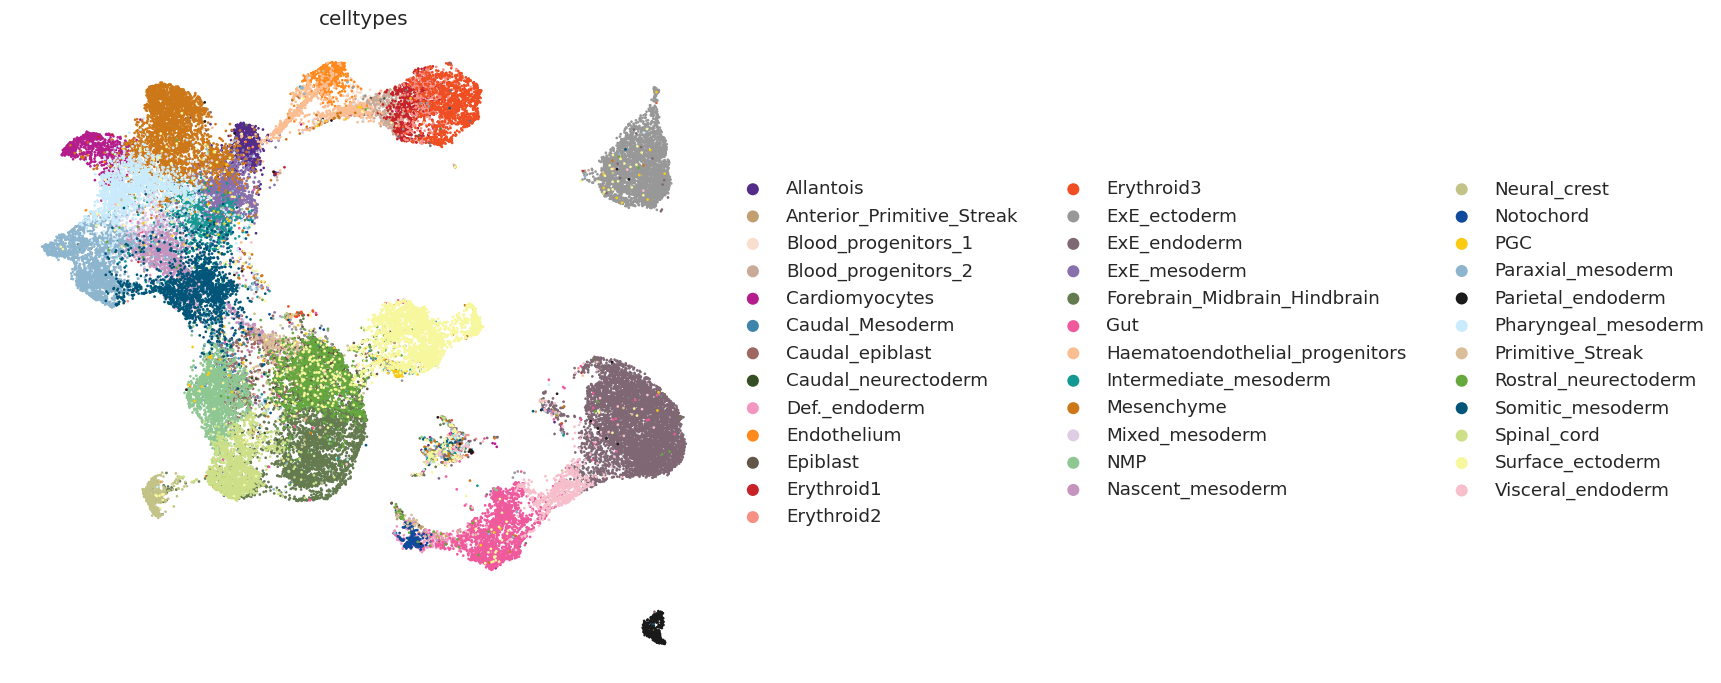

In [10]:
# Plot cell-types for reference
sc.pl.scatter(ad, basis='umap', color="celltypes", frameon=False, palette=colPalette_celltypes, size= 15)

# Running SEACells

As a rule of thumb, we recommended choosing one metacell for every 75 single-cells. Since this dataset contains ~7k cells, we choose 90 metacells.

<b>Note 1: </b> Running SEACells modifies the input Anndata object and adds the SEACell metacell assignments to the `obs` dataframe in the anndata object.
<b>Note 2: </b> This analysis takes approxmiately 5 minutes

The number of cells is a hyperparameter. You should examine the initializtation to ensure that cell states span the entirety of the phenotypic manifold.

In [11]:
np.round(45991/75)

613.0

In [12]:
## User defined parameters

## Core parameters 
# since we have 45991 cells in our dataset, we will 
#n_SEACells = 613
n_SEACells = 613

build_kernel_on = 'X_PeakVI' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 0.9 # Proportion of metacells to initialize using waypoint analysis, 
                        # the remainder of cells are selected by greedy selection

In [13]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/45986 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/45986 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/45986 [00:00<?, ?it/s]

Constructing CSR matrix...


In [14]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_PeakVI
Computing diffusion components from X_PeakVI for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 533 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/90 [00:00<?, ?it/s]

Selecting 80 cells from greedy initialization.


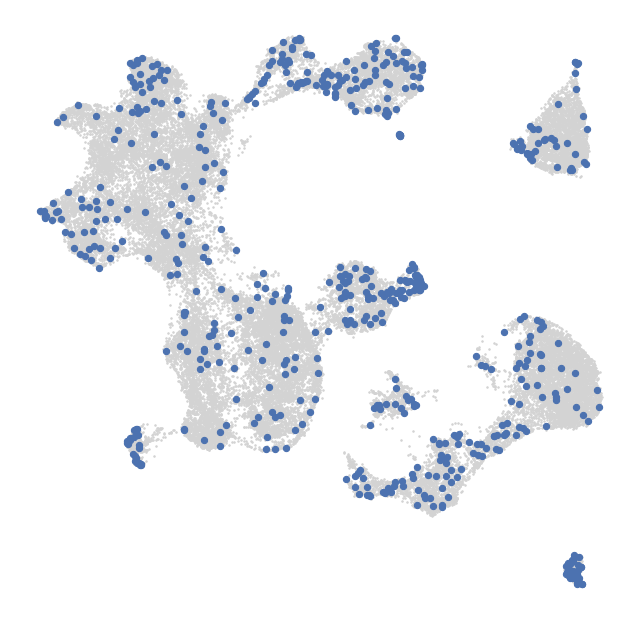

In [178]:
# Plot the initilization to ensure they are evenly spread
SEACells.plot.plot_initialization(ad, model)

In [ ]:
#model.fit(n_iter=20)

In [ ]:
#sc.write(filename = "/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/archr_sea.h5ad", adata = ad)

In [25]:
ad = sc.read( "/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/archr_sea.h5ad")

In [27]:
ad.X[1:5, 1:5].todense()

matrix([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.]], dtype=float32)

In [339]:
ad.obs.to_csv("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/archr_sea_metadata.csv", index = True)

In [338]:
ad.obs

,Sample,TSSEnrichment,ReadsInTSS,ReadsInPromoter,ReadsInBlacklist,PromoterRatio,PassQC,NucleosomeRatio,nMultiFrags,nMonoFrags,...,nDiFrags,DoubletScore,DoubletEnrichment,BlacklistRatio,celltypes,Gex_nUMI,Gex_nGenes,Gex_MitoRatio,Gex_RiboRatio,SEACell
index,,,,,,,,,,,,,,,,,,,,,
E8.5_rep1#TTACGTTTCTGGCATG-1,E8.5_rep1,3.354,15431,63227,7794,0.142428,1,1.962614,48111,74921,...,98930,5.881684,2.08,0.017557,Visceral_endoderm,22815,6593,0,0,E8.0_rep2#CGCATTTGTTGCATCT-1
E8.5_rep1#TCCTCTAAGTCCTTCA-1,E8.5_rep1,3.641,13731,53060,4630,0.176291,1,1.302408,28263,65362,...,56865,0.000000,0.74,0.015383,ExE_mesoderm,11813,4803,0,0,E8.75_rep1#AGTGCCGGTTAGGTTG-1
E8.5_rep1#TATCCAGCACAGACTC-1,E8.5_rep1,3.702,15136,57904,5587,0.192830,1,1.786256,28134,53887,...,68122,20.154291,2.88,0.018606,ExE_endoderm,45126,7926,0,0,E8.0_rep2#CGCATTTGTTGCATCT-1
E8.5_rep1#GAGAACCAGACACTTA-1,E8.5_rep1,3.526,13553,53752,5028,0.180288,1,1.584618,29038,57677,...,62358,0.000000,1.02,0.016864,ExE_endoderm,6093,3356,0,0,E8.5_rep1#TATGGCCCATGTTGGC-1
E8.5_rep1#TCAAGTATCTTAGCGG-1,E8.5_rep1,3.517,14931,59015,4617,0.215785,1,2.120251,27467,43825,...,65453,7.907777,2.22,0.016882,Erythroid1,11816,4738,0,0,E7.5_rep1#ATGCAAACAACAGCCT-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E8.0_rep2#TCATACTTCAAGACTC-1,E8.0_rep2,3.723,350,1369,97,0.223912,1,1.633075,732,1161,...,1164,0.000000,1.16,0.015865,Spinal_cord,14871,4854,0,0,E8.75_rep1#TGCCGGTAGCGAGTAA-1
E8.0_rep2#TGCACACCAATTAGCT-1,E8.0_rep2,3.276,280,1168,107,0.191727,1,1.574810,709,1183,...,1154,0.000000,0.44,0.017564,Forebrain_Midbrain_Hindbrain,9509,3976,0,0,E8.0_rep2#ATGTTCAAGGTTACGT-1
E8.0_rep2#GGCAAGCCAGCCTTGG-1,E8.0_rep2,3.456,263,1036,128,0.171070,1,2.006951,721,1007,...,1300,0.000000,0.00,0.021136,Erythroid2,11230,4355,0,0,E8.0_rep2#CCTACTGGTTGGTTAG-1


# Accessing results

## Model Convergence

In [ ]:
# Check for convergence 
model.plot_convergence()

## SEACell Assignments

These can be accessed as folows:
- in the modified anndata object in `.obs['SEAell']`
- from the model using `.get_assignments()`


In [ ]:
ad.obs[['SEACell']].head()

In [ ]:
#ad.obs[['SEACell']].reset_index(level = 0).a("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/SEACell_assignment", index = False)

In [ ]:
model.get_assignments().head()

# Summarizing data

- `core.summarize_by_SEACell()`

Datasets can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. The output of this function is an anndata object of shape n_metacells x original_data_dimension. Data is unnormalized and raw aggregated counts are stored in `X`. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

By default, `ad.raw` is used for summarization. Other layers present in the anndata can be specified using the parameter `summarize_layer` parameter

In [ ]:
# the function below requires csr as a layer key
ad.layers["csr"] = ad.X

In [ ]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='csr')
SEACell_ad

## Normalization

Normalization of metacell data can be performed using the `sc.pp.normalize_total` and `sc.pp.log1p` functions

# Evaluating Results

We provide several methods for evaluating SEACell assignments:

## Visualizing Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D()``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_SEACell_sizes()``` can be used to view the distribution of number of cells assigned to each metacell
    </ul>
    
            

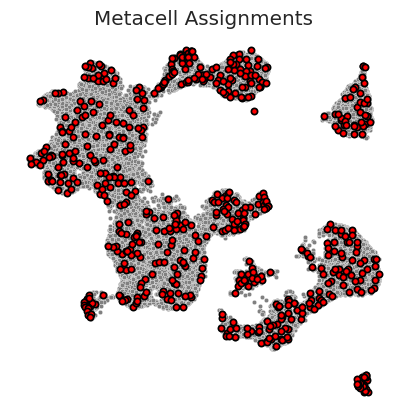

In [179]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

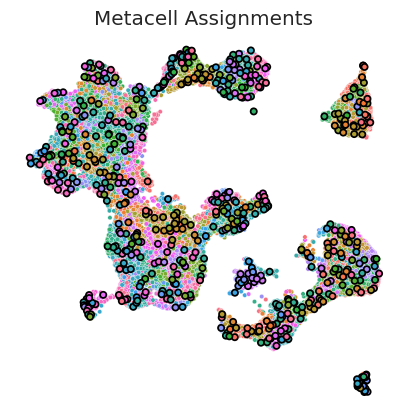

In [180]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

/omics/groups/OE0533/internal/katharina/seacells_yml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


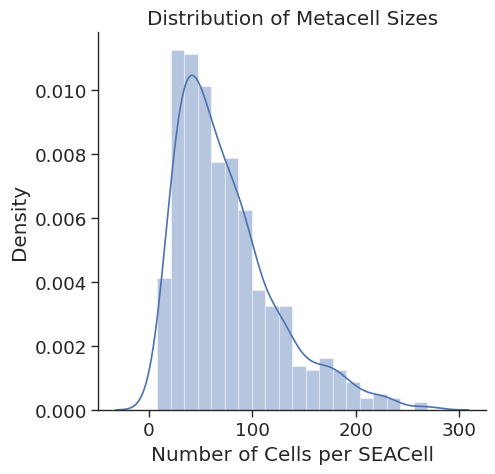

,size
SEACell,
E7.5_rep1#AAAGCACCATTTGCTC-1,72
E7.5_rep1#AACCTAATCCTCCCTC-1,43
E7.5_rep1#AACGCCCAGTCACCAG-1,75
E7.5_rep1#AATGCATGTGGATGTC-1,43
E7.5_rep1#AATGCGCGTGCTAGAC-1,97
...,...
E8.75_rep2#TGTTGTGCAACACCTA-1,75
E8.75_rep2#TTAGCTGCACTAAGAA-1,113
E8.75_rep2#TTATTGCTCCTGGTGA-1,27


In [341]:
SEACells.plot.plot_SEACell_sizes(ad, bins=20)

## Quantifying Results

SEACells also implements methods for visualizing the results of the SEACells algorithm 
    <ul> 
        <li>```.compute_celltype_purity(ad, col_name)``` computes the purity of different celltype labels within a SEACell metacell. Typically, col_name='celltype' or similar. Returns a pd.DataFrame of length n_SEACells.
        <li>```.compactness(ad, low_dim_embedding)``` computes the per-SEAcell variance in diffusion components. ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. Lower values of compactness suggest more compact/lower variance metacells.
        <li>```separation(ad, low_dim_embedding,nth_nbr=1,cluster=None)``` computes the diffusion distance between a SEACell and its ```nth_nbr```. As before, ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. If ```cluster``` is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value.  Higher values of separation suggest better distinction between metacells.
    </ul>
    


In [ ]:
ad

In [ ]:
help(SEACells.evaluate.compute_celltype_purity)

In [ ]:
ad.obs.columns

In [ ]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, col_name = 'celltypes')

In [ ]:
plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='celltypes_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

In [ ]:
compactness = SEACells.evaluate.compactness(ad, 'X_PeakVI')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

In [ ]:
separation = SEACells.evaluate.separation(ad, 'X_PeakVI',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

# Aggregating both the peak counts and the gene expression counts 

I ran this on the cluster, because it was using too much memory. (see "SEACells/cluster job for aggregation")

In [13]:
help(SEACells.genescores.prepare_multiome_anndata)

Help on function prepare_multiome_anndata in module SEACells.genescores:

prepare_multiome_anndata(atac_ad, rna_ad, SEACell_label='SEACell', n_bins_for_gc=50)
    Function to create metacell Anndata objects from single-cell Anndata objects
    
    :param atac_ad: (Anndata) ATAC Anndata object with raw peak counts in `X`. These anndata objects should be constructed 
     using the example notebook available in 
    :param rna_ad: (Anndata) RNA Anndata object with raw gene expression counts in `X`. Note: RNA and ATAC anndata objects 
     should contain the same set of cells
    :param SEACell_label: (str) `atac_ad.obs` field for constructing metacell matrices. Same field will be used for 
      summarizing RNA and ATAC metacells. 
    :param n_bins_gc: (int) Number of bins for creating GC bins of ATAC peaks.
    
    :return: ATAC metacell Anndata object and RNA metacell Anndata object



In [28]:
ad.X[1:5, 1:5].todense()

matrix([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.]], dtype=float32)

In [30]:
ad_rna.X[1:5, 1:5]#.todense()

array([[3.5172623e-05, 4.9014358e-05, 6.8418267e-05, 6.2635118e-05],
       [3.2376425e-05, 6.2930114e-05, 7.8865654e-05, 8.2073740e-05],
       [2.5634838e-05, 4.7488982e-05, 6.2396044e-05, 5.9936225e-05],
       [1.7345266e-05, 3.6643054e-05, 6.3583480e-05, 5.9451948e-05]],
      dtype=float32)

In [7]:
#atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(ad, ad_rna, SEACell_label='SEACell')
atac_meta_ad = sc.read_h5ad(data_dir + "multiome_aggregates_atac" )
rna_meta_ad = sc.read_h5ad(data_dir + "multiome_aggregates_rna")

/omics/groups/OE0533/internal/katharina/seacells_yml/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
atac_meta_ad.obs

,n_counts
E8.0_rep2#CGCATTTGTTGCATCT-1,8196.217773
E8.75_rep1#AGTGCCGGTTAGGTTG-1,16917.964844
E8.5_rep1#TATGGCCCATGTTGGC-1,9016.175781
E7.5_rep1#ATGCAAACAACAGCCT-1,15924.021484
E8.5_rep1#CTGACATAGGTCGATT-1,2940.408691
...,...
E8.5_rep2#CTGGACCAGTAACCCG-1,2863.253662
E8.5_rep2#TGGATTCAGTTCCTGC-1,1783.505249
E8.0_rep1#CGCATATAGCCTAATA-1,1375.512451
E8.75_rep1#AATCGCCCATACTCCT-1,1823.296143


### Saving RNA data

In [361]:
ad_rna.X.shape

(45986, 16701)

In [356]:
rna_meta_ad.var_names = ad_rna.var.name.to_list()

In [41]:
df = pd.DataFrame(rna_meta_ad.X.todense())

In [44]:
df.to_csv(data_dir + "SEA_aggregates_to_R/rna_agg_matrix.csv", index = False) 

In [55]:
seacell_names = pd.DataFrame(rna_meta_ad.obs_names)#.to_list()

In [57]:
seacell_names.to_csv(data_dir + "SEA_aggregates_to_R/rna_cell_names.csv", index = False)

In [359]:
pd.DataFrame(rna_meta_ad.var_names).to_csv(data_dir + "SEA_aggregates_to_R/rna_gene_names.csv", index = False)

### Saving ATAC data

In [28]:
atac_meta_ad.obs.to_csv(data_dir + "SEA_aggregates_to_R/atac_agg_colData.csv")

In [29]:
atac_meta_ad.var.to_csv(data_dir + "SEA_aggregates_to_R/atac_agg_rowData.csv")

In [63]:
pd.DataFrame(atac_meta_ad.X.todense()).to_csv(data_dir + "SEA_aggregates_to_R/peak_agg_matrix.csv", index = False)

In [64]:
pd.DataFrame(atac_meta_ad.obs_names).to_csv(data_dir + "SEA_aggregates_to_R/atac_cell_names.csv", index = False)
pd.DataFrameame(atac_meta_ad.var_names).to_csv(data_dir + "SEA_aggregates_to_R/atac_peak_names.csv", index = False)

# Gene-peak correlations

# Assign celltypes to SEACells


In [185]:
rna_meta_ad

AnnData object with n_obs × n_vars = 613 × 16701

In [259]:
ad.obs["SEACell"]

index
E8.5_rep1#TTACGTTTCTGGCATG-1     E8.0_rep2#CGCATTTGTTGCATCT-1
E8.5_rep1#TCCTCTAAGTCCTTCA-1    E8.75_rep1#AGTGCCGGTTAGGTTG-1
E8.5_rep1#TATCCAGCACAGACTC-1     E8.0_rep2#CGCATTTGTTGCATCT-1
E8.5_rep1#GAGAACCAGACACTTA-1     E8.5_rep1#TATGGCCCATGTTGGC-1
E8.5_rep1#TCAAGTATCTTAGCGG-1     E7.5_rep1#ATGCAAACAACAGCCT-1
                                            ...              
E8.0_rep2#TCATACTTCAAGACTC-1    E8.75_rep1#TGCCGGTAGCGAGTAA-1
E8.0_rep2#TGCACACCAATTAGCT-1     E8.0_rep2#ATGTTCAAGGTTACGT-1
E8.0_rep2#GGCAAGCCAGCCTTGG-1     E8.0_rep2#CCTACTGGTTGGTTAG-1
E8.0_rep2#AGTTACATCGTGCTAG-1     E8.5_rep2#GCCCAAATCGGTTCCT-1
E8.0_rep2#GCTAATATCAAACCTA-1    E8.75_rep2#AGTAGGATCGGGATTT-1
Name: SEACell, Length: 45986, dtype: category
Categories (613, object): ['E7.5_rep1#AAAGCACCATTTGCTC-1', 'E7.5_rep1#AACCTAATCCTCCCTC-1', 'E7.5_rep1#AACGCCCAGTCACCAG-1', 'E7.5_rep1#AATGCATGTGGATGTC-1', ..., 'E8.75_rep2#TTAGCTGCACTAAGAA-1', 'E8.75_rep2#TTATTGCTCCTGGTGA-1', 'E8.75_rep2#TTGCAATCACTATGGC-1', 'E8.75_

In [261]:
ad1 = ad[ad.obs["SEACell"].isin(atac_meta_ad.obs_names.to_list()), :]

In [215]:
ad[ad.obs["SEACell"].isin(rna_meta_ad.obs_names.to_list()), :]

View of AnnData object with n_obs × n_vars = 45986 × 180499
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'DoubletScore', 'DoubletEnrichment', 'BlacklistRatio', 'celltypes', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'Gex_RiboRatio', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'idx', 'GC', 'N'
    uns: 'celltypes_colors', 'neighbors', 'umap'
    obsm: 'PeakVI', 'X_PeakVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [254]:
ad.obs["SEACell"].groupby("SEACell")

KeyError: 'SEACell'

In [344]:
help(pd.Series.mode)

Help on function mode in module pandas.core.series:

mode(self, dropna: 'bool' = True) -> 'Series'
    Return the mode(s) of the Series.
    
    The mode is the value that appears most often. There can be multiple modes.
    
    Always returns Series even if only one value is returned.
    
    Parameters
    ----------
    dropna : bool, default True
        Don't consider counts of NaN/NaT.
    
    Returns
    -------
    Series
        Modes of the Series in sorted order.



In [233]:
test = pd.DataFrame(ad.obs.groupby("SEACell").apply(lambda x: pd.Series(x["celltypes"]).mode()))

In [237]:
test.SEACell.isin(rna_meta_ad.obs_names)

AttributeError: 'DataFrame' object has no attribute 'SEACell'

In [244]:
test["SEACell"] = test.index

In [246]:
test["SEACell"].isin(rna_meta_ad.obs_names)

SEACell                         
E7.5_rep1#AAAGCACCATTTGCTC-1   0    False
E7.5_rep1#AACCTAATCCTCCCTC-1   0    False
E7.5_rep1#AACGCCCAGTCACCAG-1   0    False
E7.5_rep1#AATGCATGTGGATGTC-1   0    False
E7.5_rep1#AATGCGCGTGCTAGAC-1   0    False
                                    ...  
E8.75_rep2#TGTTGTGCAACACCTA-1  0    False
E8.75_rep2#TTAGCTGCACTAAGAA-1  0    False
E8.75_rep2#TTATTGCTCCTGGTGA-1  0    False
E8.75_rep2#TTGCAATCACTATGGC-1  0    False
E8.75_rep2#TTGTCCCAGGCGCACT-1  0    False
Name: SEACell, Length: 621, dtype: bool

In [247]:
rna_meta_ad.obs_names

Index(['E8.0_rep2#CGCATTTGTTGCATCT-1', 'E8.75_rep1#AGTGCCGGTTAGGTTG-1',
       'E8.5_rep1#TATGGCCCATGTTGGC-1', 'E7.5_rep1#ATGCAAACAACAGCCT-1',
       'E8.5_rep1#CTGACATAGGTCGATT-1', 'E8.0_rep1#TTAGGCTAGGGACCTC-1',
       'E8.5_rep2#TAGTGGCGTAATGGCC-1', 'E8.75_rep2#CTTATTGGTGGATTAT-1',
       'E8.75_rep1#ATTGACTCATGTCAGC-1', 'E7.5_rep2#TGTGTGAGTGAAACAA-1',
       ...
       'E7.5_rep1#GCTGGATGTTGCGCGA-1', 'E7.5_rep2#GCTCATTGTGCTTTAC-1',
       'E7.5_rep2#CTTCAATTCACTTTAC-1', 'E7.5_rep1#AGTGGACAGTGTGATC-1',
       'E8.75_rep1#AGAAACCCACAAAGGT-1', 'E8.5_rep2#CTGGACCAGTAACCCG-1',
       'E8.5_rep2#TGGATTCAGTTCCTGC-1', 'E8.0_rep1#CGCATATAGCCTAATA-1',
       'E8.75_rep1#AATCGCCCATACTCCT-1', 'E8.0_rep2#AGCAGGTAGCTTCCCG-1'],
      dtype='object', length=613)

In [236]:
test[test.SEACell.isin(rna_meta_ad.obs_names), :]

,,celltypes
SEACell,,
E7.5_rep1#AAAGCACCATTTGCTC-1,0,Haematoendothelial_progenitors
E7.5_rep1#AACCTAATCCTCCCTC-1,0,Surface_ectoderm
E7.5_rep1#AACGCCCAGTCACCAG-1,0,Epiblast
E7.5_rep1#AATGCATGTGGATGTC-1,0,Visceral_endoderm
E7.5_rep1#AATGCGCGTGCTAGAC-1,0,ExE_ectoderm
...,...,...
E8.75_rep2#TGTTGTGCAACACCTA-1,0,Somitic_mesoderm
E8.75_rep2#TTAGCTGCACTAAGAA-1,0,NMP
E8.75_rep2#TTATTGCTCCTGGTGA-1,0,Gut


In [262]:
rna_meta_ad.obs["celltype"] = ad1.obs.groupby("SEACell").apply(lambda x: pd.Series(x["celltypes"]).mode())

In [274]:
x = ad1.obs.groupby("SEACell").apply(lambda x: pd.Series(x["celltypes"]).mode())#

In [292]:
pd.DataFrame(x.index.get_level_values(0).tolist())[0].isin(rna_meta_ad.obs_names)#)== False)

0      True
1      True
2      True
3      True
4      True
       ... 
616    True
617    True
618    True
619    True
620    True
Name: 0, Length: 621, dtype: bool

In [271]:
ad.obs.SEACell.unique().shape

(613,)

In [263]:


rna_meta_ad.obs

,celltype,n_counts,celltypes
E8.0_rep2#CGCATTTGTTGCATCT-1,NaN,10000.000977,NaN
E8.75_rep1#AGTGCCGGTTAGGTTG-1,NaN,10000.000000,NaN
E8.5_rep1#TATGGCCCATGTTGGC-1,NaN,9999.998047,NaN
E7.5_rep1#ATGCAAACAACAGCCT-1,NaN,10000.000000,NaN
E8.5_rep1#CTGACATAGGTCGATT-1,NaN,10000.000000,NaN
...,...,...,...
E8.5_rep2#CTGGACCAGTAACCCG-1,NaN,10000.000977,NaN
E8.5_rep2#TGGATTCAGTTCCTGC-1,NaN,10000.000977,NaN
E8.0_rep1#CGCATATAGCCTAATA-1,NaN,9999.999023,NaN
E8.75_rep1#AATCGCCCATACTCCT-1,NaN,9999.999023,NaN


In [201]:
rna_meta_ad.obs["celltypes"] = ad.obs.groupby("SEACell").apply(lambda x: pd.Series(x["celltypes"]).mode())#.to_list()

ValueError: Length of values (621) does not match length of index (613)

In [202]:
rna_meta_ad.obs

,celltype,n_counts,celltypes
E8.0_rep2#CGCATTTGTTGCATCT-1,NaN,10000.000977,NaN
E8.75_rep1#AGTGCCGGTTAGGTTG-1,NaN,10000.000000,NaN
E8.5_rep1#TATGGCCCATGTTGGC-1,NaN,9999.998047,NaN
E7.5_rep1#ATGCAAACAACAGCCT-1,NaN,10000.000000,NaN
E8.5_rep1#CTGACATAGGTCGATT-1,NaN,10000.000000,NaN
...,...,...,...
E8.5_rep2#CTGGACCAGTAACCCG-1,NaN,10000.000977,NaN
E8.5_rep2#TGGATTCAGTTCCTGC-1,NaN,10000.000977,NaN
E8.0_rep1#CGCATATAGCCTAATA-1,NaN,9999.999023,NaN
E8.75_rep1#AATCGCCCATACTCCT-1,NaN,9999.999023,NaN


### Normalize and log transform this new data

This is very important to normalize again.

In [191]:
help(sc.pp.log1p)

Help on function log1p in module scanpy.preprocessing._simple:

log1p(X: Union[anndata._core.anndata.AnnData, numpy.ndarray, scipy.sparse._base.spmatrix], *, base: Union[numbers.Number, NoneType] = None, copy: bool = False, chunked: bool = None, chunk_size: Union[int, NoneType] = None, layer: Union[str, NoneType] = None, obsm: Union[str, NoneType] = None)
    Logarithmize the data matrix.
    
    Computes :math:`X = \log(X + 1)`,
    where :math:`log` denotes the natural logarithm unless a different base is given.
    
    Parameters
    ----------
    X
        The (annotated) data matrix of shape `n_obs` × `n_vars`.
        Rows correspond to cells and columns to genes.
    base
        Base of the logarithm. Natural logarithm is used by default.
    copy
        If an :class:`~anndata.AnnData` is passed, determines whether a copy
        is returned.
    chunked
        Process the data matrix in chunks, which will save memory.
        Applies only to :class:`~anndata.AnnData`.
   

In [192]:
# Normalize and log transform the data
sc.pp.normalize_per_cell(rna_meta_ad, counts_per_cell_after=10000)
sc.pp.log1p(rna_meta_ad)

# Select highly variable genes
sc.pp.highly_variable_genes(rna_meta_ad)

# Perform PCA and UMAPs
sc.tl.pca(rna_meta_ad, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(rna_meta_ad, n_neighbors=5)
sc.tl.umap(rna_meta_ad)

/omics/groups/OE0533/internal/katharina/seacells_yml/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [196]:
rna_meta_ad.obs

,celltype,n_counts
E8.0_rep2#CGCATTTGTTGCATCT-1,NaN,10000.000977
E8.75_rep1#AGTGCCGGTTAGGTTG-1,NaN,10000.000000
E8.5_rep1#TATGGCCCATGTTGGC-1,NaN,9999.998047
E7.5_rep1#ATGCAAACAACAGCCT-1,NaN,10000.000000
E8.5_rep1#CTGACATAGGTCGATT-1,NaN,10000.000000
...,...,...
E8.5_rep2#CTGGACCAGTAACCCG-1,NaN,10000.000977
E8.5_rep2#TGGATTCAGTTCCTGC-1,NaN,10000.000977
E8.0_rep1#CGCATATAGCCTAATA-1,NaN,9999.999023
E8.75_rep1#AATCGCCCATACTCCT-1,NaN,9999.999023


In [195]:
sc.pl.scatter(rna_meta_ad, basis='umap', color='celltype', frameon=False)


ValueError: key 'celltype_colors' is invalid! pass valid observation annotation, one of ['celltype', 'n_counts'] or a gene name Index(['chr1:3214482-3671498', 'chr1:4290846-4409241', 'chr1:4490928-4497354',
       'chr1:4773198-4785726', 'chr1:4807893-4846735', 'chr1:4857694-4897909',
       'chr1:4909576-5070285', 'chr1:5083086-5162549', 'chr1:5588493-5606133',
       'chr1:5913707-5917398',
       ...
       'chrX:167207094-167209218', 'chrX:167346320-167382749',
       'chrX:167471306-168577233', 'chrX:168653099-168673902',
       'chrX:168795099-169304440', 'chrX:169251538-169320372',
       'chrX:169320422-169368178', 'chrX:169685199-169990798',
       'chrX:169776378-169779635', 'chrX:170672644-170678054'],
      dtype='object', length=16701)

# ChromVar

First we will create an anndata object containing the motif deviations. We will add the ATAC UMAP as well. 

In [312]:
# get umap coordinates from original anndata object
atac_umap = pd.DataFrame(ad.obsm["X_umap"], index = ad.obs_names)

In [313]:
# take mean coordinate for SEACell aggregates and add to aggregate anndata objects
atac_meta_ad.obsm["X_umap"] = atac_umap.groupby(ad.obs["SEACell"]).mean().loc[atac_meta_ad.obs_names, :].values
rna_meta_ad.obsm["X_umap"] = atac_umap.groupby(ad.obs["SEACell"]).mean().loc[atac_meta_ad.obs_names, :].values

In [314]:
# read in deviation matrix
dev = pd.read_csv(data_dir + "SEA_aggregates_to_R/deviations.csv", index_col = 0)
dev_matrix = dev.to_numpy()

In [315]:
# create anndata for peaks
dev_ad = sc.AnnData(dev.to_numpy().T)
dev_ad.obs_names = dev.columns
dev_ad.var_names = dev.index
dev_ad.obsm["X_umap"] = rna_meta_ad.obsm["X_umap"]

/tmp/ipykernel_45494/437358887.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dev_ad = sc.AnnData(dev.to_numpy().T)


In [152]:
rna_meta_ad.var = ad_rna.var

In [111]:
rna_meta_ad.var_names = ad_rna.var["name"].to_list()
rna_meta_ad.var = ad_rna.var

In [112]:
rna_meta_ad.var_names

Index(['Xkr4', 'Rp1', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h',
       'Oprk1', 'Npbwr1',
       ...
       'Tmsb4x', 'Prps2', 'Frmpd4', 'Msl3', 'Arhgap6', 'Hccs', 'Gm15246',
       'Mid1', '4933400A11Rik', 'Asmt'],
      dtype='object', length=16701)

In [113]:
genes = ["Gata2", "Gata1"]
temp = rna_meta_ad[:, genes]

In [115]:
atac_meta_ad

AnnData object with n_obs × n_vars = 613 × 180499
    obs: 'n_counts'
    var: 'GC_bin', 'counts_bin'
    obsm: 'X_umap'

In [120]:
ad_rna.obsm["X_umap"] = ad.obsm["X_umap"]

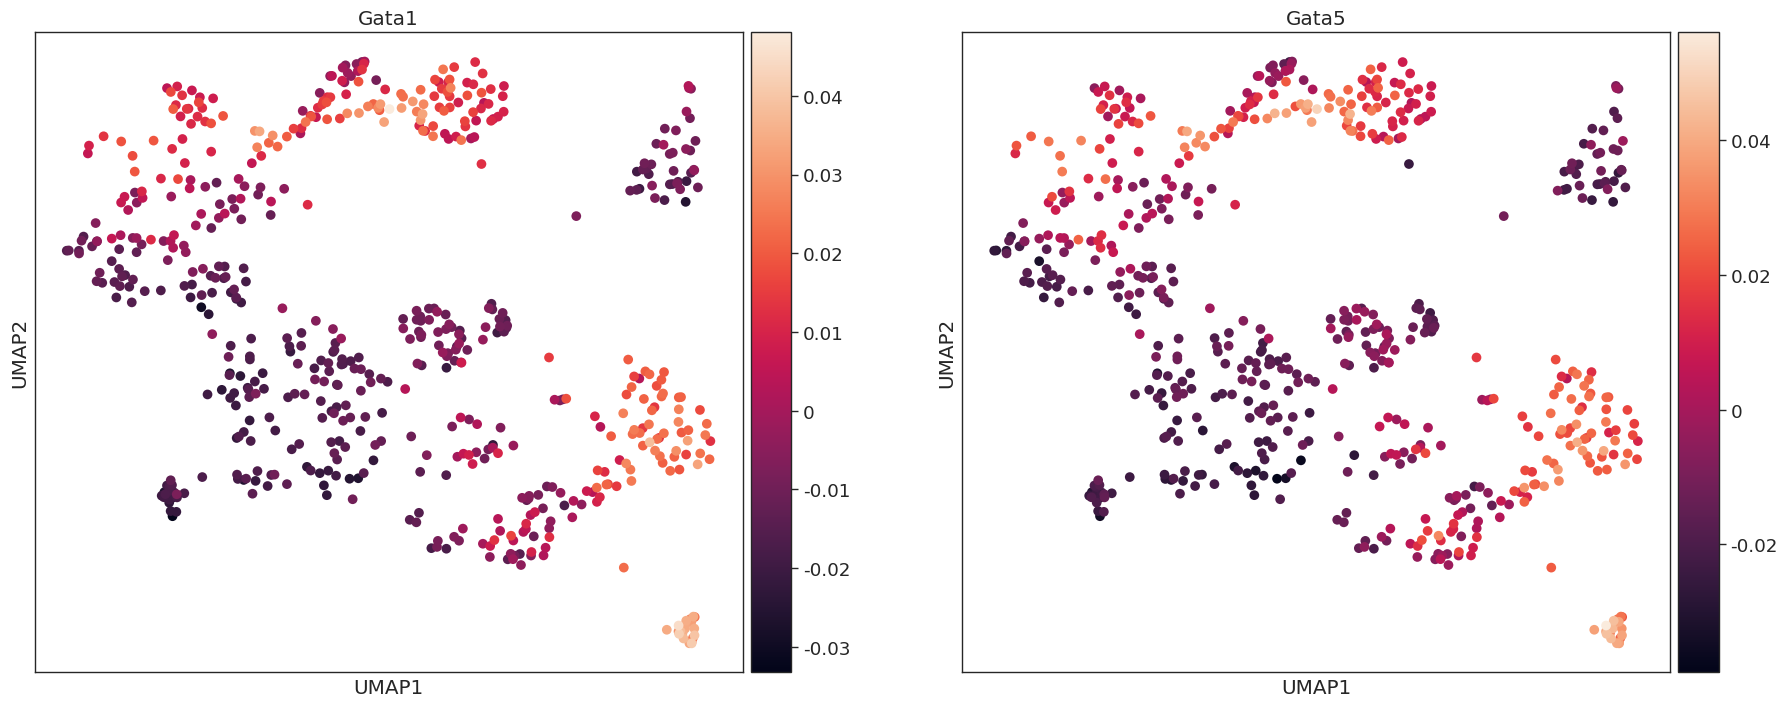

In [365]:
sc.pl.scatter(dev_ad, basis = "umap", color = ["Gata1387", "Gata5385"], title = ["Gata1", "Gata5"])

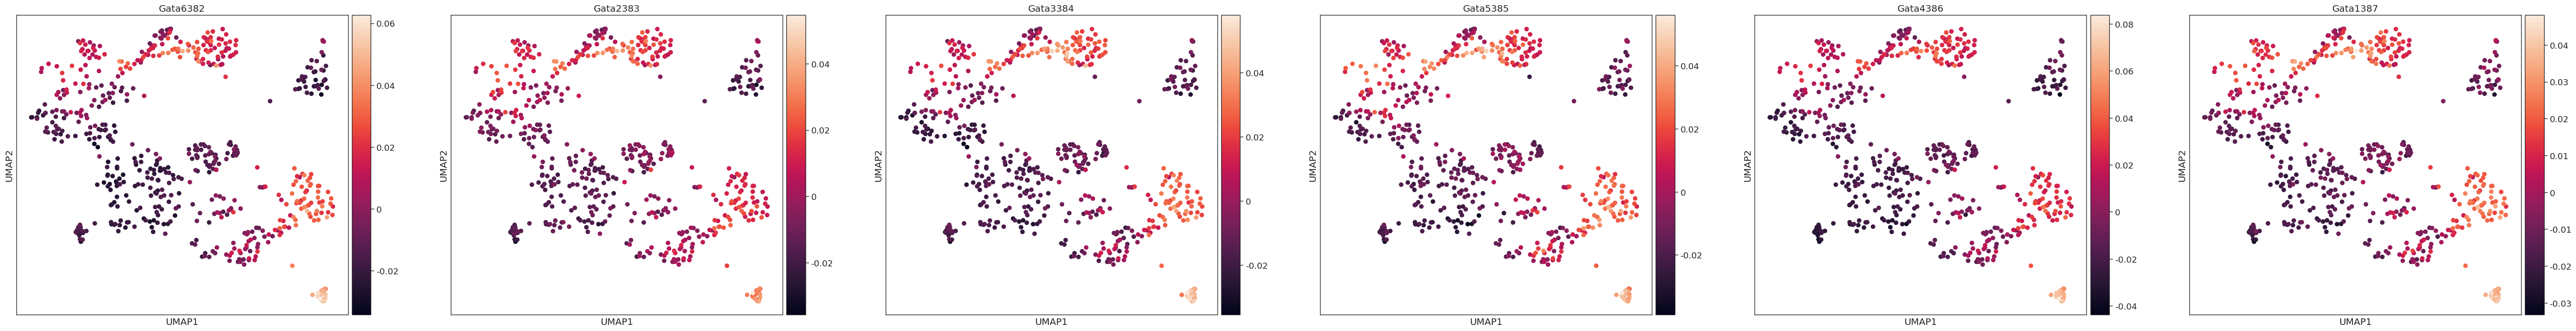

In [330]:
sc.pl.scatter(dev_ad, basis = "umap", color = ["Gata6382", "Gata2383", "Gata3384", "Gata5385", "Gata4386", "Gata1387"], )

In [90]:
temp.layers["GeneAccessibility"] = atac_meta_ad[rna_meta_ad.obs_names].obsm["GeneAccessibility"][genes].values

KeyError: 'GeneAccessibility'